# r/Place Data Visualization

This is a short guide describing the process I use to create 3D data visualizations in Blender. There are four main steps:

1. Trimming and formatting the dataset
2. Sorting the dataset
3. Generating color and height maps from the dataset
4. Using the color and height maps to create the visualization in Blender

## Trimming and Formatting the Dataset

Shortly after the end of r/Place 2022, Reddit released a [dataset](https://www.reddit.com/r/place/comments/txvk2d/rplace_datasets_april_fools_2022/) containing the timestamp, user ID (hashed), pixel color, and coordinates of every tile placed throughout the entire event (that's about 160 million tiles!). Here's a sample the data from the CSV file:

|timestamp                  |user_id                                                                                 |pixel_color|coordinate         |
|---------------------------|----------------------------------------------------------------------------------------|-----------|-------------------|
|2022-04-04 00:53:51.577 UTC|ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8alFy/6GtNkYp5MSic6Tjo/fBCCGe6oZKMAN3rEZHw==|#00CCC0    |826,1048           |
|2022-04-04 00:53:53.758 UTC|6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3dMib91oUWONX96g5PPcioIxedF24ldNOu/g5yqDrg==|#94B3FF    |583,1031           |
|2022-04-04 00:53:54.685 UTC|O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWbNLhLKmLI4gn1QPbaABqZqmFC/OmE/O732n39dGIQ==|#6A5CFF    |1873,558           |
|2022-04-04 00:54:57.541 UTC|tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQELrEzZBCmGe28NWM+O1IdfH4CieCpEnE5sHecW9Ow==|#009EAA    |1627,255           |
|2022-04-04 00:55:16.307 UTC|OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUrJE7lpGFevfV9w+zImFimmNANlDdfN3kluz69M9MQ==|#94B3FF    |49,1478            |
|2022-04-04 00:55:20.64 UTC |A0HdtcPvI7ipKivvXNVZDa3gkcjGXFjNxF5tca5QXazENCGVR8d3j65QVgnaVIgvGbdtiGuSvRs1rAj2f1oMAQ==|#E4ABFF    |408,1863           |
|2022-04-04 00:55:34.898 UTC|1U4LPuB22P6Yf7eRhKz6zU1dFMK5wXIzsNVPUNhP7eHIwGuMfnDz/hDh/8QhDug6qqsKXHYvgH9L5FnWNMGm3A==|#94B3FF    |111,1582           |
|2022-04-04 00:55:57.168 UTC|tPcrtm7OtEmSThdRSWmB7jmTF9lUVZ1pltNv1oKqPY9bom/EGIO3/b5kjRenbD3vMF48psnR9MnhIrTT1bpC9A==|#6A5CFF    |1908,1854          |
|2022-04-04 00:55:40.375 UTC|0AGoMGF50j0DJDc+704SwMylU90YDILDIgo8WOetgpiEWGEhMB3Eh8Q8r+Wa9XIJhQZQcOquqpRgZ5REB4jrOA==|#6A5CFF    |1134,1640,1135,1641|


This initial form of the dataset provided by Reddit isn't well suited for making our animation. Some things could be better:

- The bulk of the file comes from the `user_id` column, which we don't care about.
- The timestamp is a long string, and it's in a format that's expensive to parse. It would be better if it were just milliseconds as an integer.
- There is only one `coordinate` column, which contains the x and y values separated by a comma. There should be separate x and y columns.
- The r/Place admins used a "rectangle drawing tool" to cover "inappropriate content" on 21 occasions. These rectangles are given with four coordinates (x1, y1, x2, y2). The last row of the sample data is an example of this.
- The `pixel_color` column gives the colors in hex format. There were only 32 colors to choose from, so we could cut this down significantly by assigning each color a number. It would also make the CSV faster to load.

Lets start first with making functions to convert our timestamps, pixel colors, and coordinates into a more suitable format.

### Format dates with `parse_timestamp()`

Reformatting the YYYY-MM-DD HH:MM:SS.SSS timestamp to milliseconds will cut down the resulting file size significantly. It will also be much faster to sort, and it's a better format for the calcuations we will perform later. We can also subtract the POSIX timestamp of the earliest pixel to reduce the size of the timestamp to a number that fits into a 32-bit unsigned integer.

In [1]:
from datetime import datetime

def parse_timestamp(timestamp):
    """Convert a YYYY-MM-DD HH:MM:SS.SSS timestamp to milliseconds after the start of r/Place 2022."""
    date_format = "%Y-%m-%d %H:%M:%S.%f"
    try:
        timestamp = datetime.strptime(timestamp[:-4], date_format).timestamp()
    except ValueError:
        # The timestamp is exactly on the second, so there is no decimal (%f).
        # This happens 1/1000 of the time.
        timestamp = datetime.strptime(timestamp[:-4], date_format[:-3]).timestamp()

    # Convert from a float in seconds to an int in milliseconds
    timestamp *= 1000.0
    timestamp = int(timestamp)

    # The earliest timestamp is 1648806250315, so subtract that from each timestamp
    # to get the time in milliseconds since the beginning of the experiment.
    timestamp -= 1648806250315

    return str(timestamp)

### Format colors with `parse_pixel_color()`

We can save storage space by asigning each of the 32 colors used in the event to an integer key. This key fits in an 8-bit unsigned integer, and can later be used to convert back to the color value.

In [2]:
def parse_pixel_color(pixel_color):
    """Convert a hex color code to an integer key."""
    hex_to_key = {
        "#000000": "0",
        "#00756F": "1",
        "#009EAA": "2",
        "#00A368": "3",
        "#00CC78": "4",
        "#00CCC0": "5",
        "#2450A4": "6",
        "#3690EA": "7",
        "#493AC1": "8",
        "#515252": "9",
        "#51E9F4": "10",
        "#6A5CFF": "11",
        "#6D001A": "12",
        "#6D482F": "13",
        "#7EED56": "14",
        "#811E9F": "15",
        "#898D90": "16",
        "#94B3FF": "17",
        "#9C6926": "18",
        "#B44AC0": "19",
        "#BE0039": "20",
        "#D4D7D9": "21",
        "#DE107F": "22",
        "#E4ABFF": "23",
        "#FF3881": "24",
        "#FF4500": "25",
        "#FF99AA": "26",
        "#FFA800": "27",
        "#FFB470": "28",
        "#FFD635": "29",
        "#FFF8B8": "30",
        "#FFFFFF": "31",
    }

    return hex_to_key[pixel_color]

### Format Coordinates with `parse_coordinate()`

The Reddit dataset contains the xy coordinates in a single column. Each coordinate is given as a string of coordinates separated by commas (for example: `"1627,255"`). As mentioned previously, some of the coordinates are given with four values to represent a rectangle. We'll revisit to that problem soon.

In [3]:
def parse_coordinate(coordinate):
    """Split the coordinate string into two numbers."""
    return coordinate.split(",")

### Putting it All Together

Now that we have our parsers for the desired columns, we can use them with Python standard library `csv` module to convert the Reddit dataset to an optimized CSV format. After that, we can save ourselves some storage space by deleting the original dataset.

In [4]:
import csv


INFILE_PATH = 'data/2022_place_canvas_history.csv'
TRIMMED_PATH = 'data/2022_place_canvas_history_trimmed.csv'
SORTED_PATH = 'data/2022_place_canvas_history_sorted.csv'


with open(INFILE_PATH, "r") as infile:
    reader = csv.reader(infile)

    with open(TRIMMED_PATH, "w", newline="") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(["timestamp", "pixel_color", "x", "y"])

        # Skip the infile header.
        next(reader)

        i = 0
        for row in reader:
            timestamp = parse_timestamp(row[0])
            pixel_color = parse_pixel_color(row[2])
            try:
                x, y = parse_coordinate(row[3])
            except ValueError:
                # The coordinate is a rectangle with x1, y1, x2, and y2 coordinates.
                # Convert the rectangle into points.
                x1, y1, x2, y2 = [int(i) for i in row[3].split(",")]
                width = x2 - x1 + 1
                height = y2 - y1 + 1

                for i in range(width):
                    for j in range(height):
                        x = x1 + i
                        y = y1 + j
                        writer.writerow([timestamp, pixel_color, x, y])
                continue

            new_row = [timestamp, pixel_color, x, y]
            writer.writerow(new_row)
            
            i += 1
            if i % 1_000_000 == 0:
                # Print a '.' every million lines so we know that something is happening.
                print(".", end="")
        print()

# Print the result.
with open(TRIMMED_PATH, "r") as f:
    for _ in range(10):
        print(next(f), end="")

............................................................................................................................................................
timestamp,pixel_color,x,y
216581262,5,826,1048
216583443,17,583,1031
216584370,11,1873,558
216647226,2,1627,255
216665992,17,49,1478
216670325,23,408,1863
216684583,17,111,1582
216690060,11,1334,1840
216706853,11,1908,1854


## Sorting the Dataset

Now that we've reformatted the dataset, we can load it into a Pandas dataframe with a fraction of the memory that would have been needed to hold the original format. Furthermore, we've already performed much of the heavy lifting required to parse the information.

In [5]:
import pandas as pd

df = pd.read_csv(
    TRIMMED_PATH,
    dtype={
        "timestamp": "uint32",
        "pixel_color": "uint8",
        "x": "uint16",
        "y": "uint16",
    },
)

df.sort_values("timestamp", inplace=True)
df.to_csv(SORTED_PATH, index=False)
df.head()

,timestamp,pixel_color,x,y
18172799,0,14,42,42
18172800,12356,3,999,999
18172801,16311,7,44,42
18172802,21388,21,2,2
18172803,34094,7,23,23


## Generating Color and Age Maps

The final step before moving on to Blender is generating the color and age maps. For this, we will use an image processing library named [Pillow](https://pillow.readthedocs.io/en/stable/).

### The Problem With 16-bit Age Maps

In my first renders, I simply saved the age of each pixel as a 16-bit integer in the age maps. If we record the pixel value as the age of the pixel in milliseconds, that means the pixel has an "age resolution" of 1 millisecond with a maximum age of 65.535 seconds. If we change the age resolution 100 milliseconds, that means we have a maximum age of 65,535 * 100 milliseconds = 6,553.5 seconds.

Setting the age resolution too high results in short lived pixels. Setting the age resolution too low results in several pixels that have the same age, and are less accurate.

However, this problem can be overcome with some math. Consider our final render, where the pixel's age corresponds to its height in the image. The heights of the pixels will be the most varied in the moments right after the pixel is changed. As the pixel gets older, it's change in height over time will be smaller and less important.

It would be nice if we could trade some of the unnecessary resolution in our old pixels for higher resolution in our new pixels. Fortunately, we can do this with logorithms.

Let's quickly review what a logorithmic scale looks like.

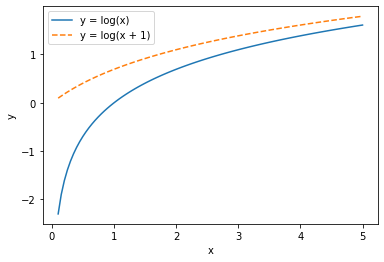

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0.1, 5, 100)
y1 = np.log(x)
y2 = np.log(x + 1)

plt.plot(x, y1)
plt.plot(x, y2, linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['y = log(x)', 'y = log(x + 1)'])

fig = plt.figure()
plt.show()

Notice how for log(x), y approaches negative infinity as x decreases to zero. Pixels start with an age of zero, and negative infinity doesn't fit in a `uint16` pixel value. This can be fixed by simply adding 1 to `x`, which makes `y` equal to zero when `x` equals zero.

How can using `log` help us reach our goal of trading age resolution on the high end for age resolution on the low end? Consider how the values for `x` near zero cover a much wider range of `y` of compared to higher values of `x`. This can be useful to us, since we want high age resolution for low (new) values, but we don't care so much about age resolution for high (old) values.

We just need to scale the curve so that the it has the desired steepness (we'll call this 'compression'), and the oldest pixels have a value close to the maximum value of a 16-bit `uint` (65545).

We will do this with a function called `age_to_val()`:

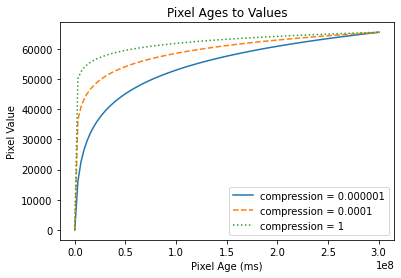

<Figure size 432x288 with 0 Axes>

In [7]:
UINT16_MAX = 65_535
TIMESTAMP_MAX = 300_589_892


In [ ]:

def age_to_val(px_age, compression=0.0001):
    """Convert a pixel age into a 16-bit value.

    Higher compression values make the transformation more extreme (less linear).
    Tip: If you change the compression value here, you will also need to change it
    in Blender's Geometry Nodes modifier settings!
    """

    # Higer compression values make the transformation more extreme.
    # This values needs to match the value in the Blender Geometry Nodes modifier.
    # With a compression to 0.0001, the age resolution begins at about 1 ms and
    # increases gradually with the age.

    # Scale along the x-axis.
    scaled_age = px_age * compression

    # Scale along the y-axis.
    scaling_const = UINT16_MAX / np.log(TIMESTAMP_MAX * compression + 1)

    return scaling_const * np.log(scaled_age + 1)


# The pixel age is our x axis.
px_age = np.linspace(0, TIMESTAMP_MAX, 100)

# The pixel value is our y axis.
px_val_low_compression = age_to_val(px_age, compression=0.000001)
px_val_default_compression = age_to_val(px_age)
px_val_high_compression = age_to_val(px_age, compression=1)

plt.plot(px_age, px_val_low_compression)
plt.plot(px_age, px_val_default_compression, linestyle='--')
plt.plot(px_age, px_val_high_compression, linestyle=':')

# Add legends
plt.legend(['compression = 0.000001', 'compression = 0.0001', 'compression = 1'])

plt.title('Pixel Ages to Values')
plt.xlabel('Pixel Age (ms)')
plt.ylabel('Pixel Value')

fig = plt.figure()
plt.show()

## Iterating Through the Dataset

At this point, we have our dataset prepared and we have a way of converting pixel ages to pixel values. Now we can start iterating through the dataset to generate the color and age maps.

- Generate two blank 2000x2000 "canvases":
  - `img_color`: a Pillow `Image` object to hold the running color map. The initial color is white, so that the untouched pixels count as the maximum age.
  - `px_birthtimes`: A 32-bit unsigned integer NumPy 2D array. Each value represents the timestamp of the most recent pixel to be placed there. The intial values are all zero, but zeros are treated as a special case where it means the pixel has never been changed.
- Load the dataset into a Pandas dataframe called `df`.

In [8]:
import os
from PIL import Image
import numpy as np

timescale = 100  # 100 = 100x speed
fps = 60

# How many milliseconds the first frame will be captured after the start of the event.
start_time = 3_000_000

# The birthtime of the oldest pixel in the dataset, in milliseconds.
TIMESTAMP_MAX = 300_589_892
UINT16_MAX = 2**16 - 1

# The time gap between frames.
dt = round(timescale * 1000 / fps)

# earlier we converted the hex colors from the r/Place dataset to a key.
# We can use this tuple to convert the key to an RGB color.
indexed_rgb = (
    (0, 0, 0),
    (0, 117, 111),
    (0, 158, 170),
    (0, 163, 104),
    (0, 204, 120),
    (0, 204, 192),
    (36, 80, 164),
    (54, 144, 234),
    (73, 58, 193),
    (81, 82, 82),
    (81, 233, 244),
    (106, 92, 255),
    (109, 0, 26),
    (109, 72, 47),
    (126, 237, 86),
    (129, 30, 159),
    (137, 141, 144),
    (148, 179, 255),
    (156, 105, 38),
    (180, 74, 192),
    (190, 0, 57),
    (212, 215, 217),
    (222, 16, 127),
    (228, 171, 255),
    (255, 56, 129),
    (255, 69, 0),
    (255, 153, 170),
    (255, 168, 0),
    (255, 180, 112),
    (255, 214, 53),
    (255, 248, 184),
    (255, 255, 255),
)

# Generate the canvases to hold the running values
img_color = Image.new("RGB", (2000, 2000), "white")
px_birthtimes = np.zeros((2000, 2000), dtype="uint32")

# Load the dataset we processed and sorted earlier.
df = pd.read_csv(
    SORTED_PATH,
    dtype={
        "timestamp": "uint32",
        "pixel_color": "uint8",
        "x": "uint16",
        "y": "uint16",
    },
)

# Create an iterator that yields the rows of the dataset in order.
px_iterator = df.itertuples()

# Skip the header row.
px = next(px_iterator)

# Create "frames_color" and "frames_age" directories if they don't already exist.
if not os.path.exists("frames_color"):
    os.mkdir("frames_color")
if not os.path.exists("frames_age"):
    os.mkdir("frames_age")


# Iterate through the frames.
for ms in range(start_time, TIMESTAMP_MAX, dt):
    # Draw pixels where timestamp == ms
    # There may be multiple pixels with the same timestamp.
    while px.timestamp <= ms:
        # Draw the pixel's color to the color canvas.
        img_color.putpixel(
            (px.x, px.y),
            indexed_rgb[px.pixel_color],
        )
        # Draw the pixel's birthtime to the birthtime canvas.
        px_birthtimes[px.y, px.x] = px.timestamp
        try:
            # Get the next pixel.
            px = next(px_iterator)
        except StopIteration:
            # Break out of the loop if we've reached the end of the dataset.
            break

    # After all of the pixels less than the frame's timestamp have been drawn,
    # save the color and birthtime canvases as frames.

    filename = f"frame-{str((ms - start_time)//dt).zfill(4)}.png"
    
    # Subtract the birthtimes of the pixels from the current time to get their ages.
    # If the pixel has a timestamp of 0, treat it as having max age.
    # (it's one of the original white pixels)
    px_ages = np.where(px_birthtimes == 0, UINT16_MAX, age_to_val(ms - px_birthtimes))
    
    # Convert the NumPy array to a Pillow 16-bit Image object.
    img_age = Image.fromarray(px_ages.astype("uint16"), "I;16")

    # Save the frames.
    img_age.save(f"frames_age/{filename}", "PNG", optimize=True, bits=16)
    img_color.save(f"frames_color/{filename}", "PNG", optimize=True)


KeyboardInterrupt: 